In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from tqdm.auto import tqdm
import seaborn as sns
import scipy.stats as stats


from src.colorconv import ConvexCluster
from src.util import (non_dominated_front,
                      compression,
                      informativeness,
                      degree_of_convexity_cielab,
                      plot_color_grid,
                      plot_n_neighbours,
                      letter_subplots)

from adjustText import adjust_text


sns.set(context='paper', style='ticks', font_scale=1)

### 0. Defining functions, loading data and plotting misclellaneous figures

Function for artificial data generation:

In [2]:
def generate_grid(n, n_low, n_high, d, X, Y, cielab_list, cielab_dict, cielab_dict_r, prior_m_matrix):
    '''
    Function to generate a set of artificial color systems with different
    degrees of convexity.
    '''
    c_values = np.random.uniform(0.001, 0.1, n)
    s_values = np.random.uniform(0.8, 1, n)

    mdl_values = []
    conv_values = []
    cost_values = []
    categ = []
    param_dict = {}
    lgs = []

    for i, sc in tqdm(enumerate(zip(s_values, c_values)), total=n, desc='Generating Grid'):
        N = np.round(np.random.uniform(n_low, n_high), 0).astype(int)
        a = ConvexCluster(X = np.zeros((X, Y)), 
                        d = d, 
                        N = N,
                        s = sc[0], 
                        c = sc[1],
                        coords=cielab_list,
                        reverse_labels=cielab_dict_r)
        l = a.run()
        
        lgs.append(l)
        param_dict[i] = (sc[0], sc[1], N)
        mdl_values.append(compression(l))
        conv_values.append(a.degree_of_convexity())
        cost_values.append(informativeness(l, 
                                           prior_m_matrix, 
                                           cielab_dict))
        categ.append(N)
    
    return mdl_values, conv_values, cost_values, categ, param_dict, lgs

Unpicking the data:

In [3]:
# unpockle IB_color_naming.pkl from data
with open('data/IB_color_naming.pkl', 'rb') as f:
    IB_color_naming = pickle.load(f)

# unpickle chip dict
with open('data/chip_dict.pkl', 'rb') as f:
    chip_dict = pickle.load(f)

# unpickle sielab_dict
with open('data/cielab_dict.pkl', 'rb') as f:
    cielab_dict = pickle.load(f)   

# unpickle rgb_dict
with open('data/rgb_dict.pkl', 'rb') as f:
    rgb_dict = pickle.load(f)

# unpickle languages
with open('data/lg_color.pkl', 'rb') as f:
    lg_color = pickle.load(f)

# unpickle lang_info
with open('data/lang_info.pkl', 'rb') as f:
    lang_info = pickle.load(f)

Loading the IB prior data:

In [4]:
prior_m = IB_color_naming['pM']

# match index of prior_m to chip_dict coordinates 
# and build a new dict (coordinate: probability)
prior_m_ = []
for i, p in enumerate(prior_m):
    prior_m_.append((chip_dict[i+1], p))

# remove entries with first coordinate == 1
prior_m_ = [x for x in prior_m_ if x[0][1] != 0]

# use coordinate from prior_m_ to build a matrix with probabilities
prior_m_matrix = np.zeros((8, 40))
for c, p in prior_m_:
    prior_m_matrix[c[0]-1, c[1]-1] = p

Exponential demonstration:

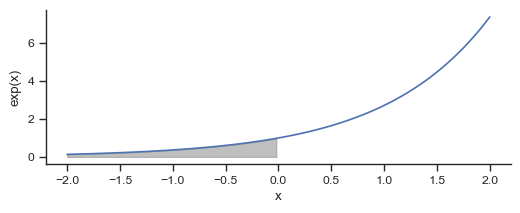

In [5]:
# plot exp of x from -5 to 5
plt.figure(figsize=(6, 2))
x = np.linspace(-2, 2, 100)
y = np.exp(x)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('exp(x)')
# color with grey from -2 to 0
plt.fill_between(x, y, where=x < 0, color='grey', alpha=0.5)
sns.despine()
plt.show()

IB prior demonstration:

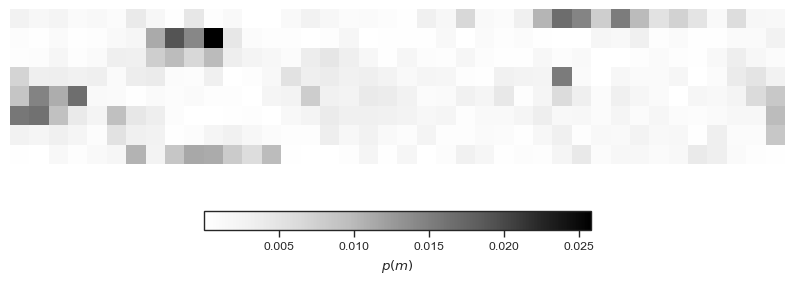

In [6]:
plt.figure(figsize=(10, 4))
plt.imshow(prior_m_matrix, cmap='Greys', interpolation='none')

# remove axes
plt.axis('off')

# Add colorbar at the bottom
cbar = plt.colorbar(orientation='horizontal', shrink=0.5)
cbar.set_label('$p(m)$')

plt.savefig('figures/supplement/Figure_1s.pdf', dpi=300, bbox_inches='tight')
plt.show()

Munsell color space:

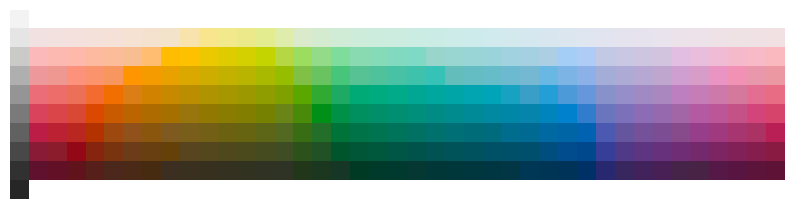

In [7]:
# Extract coordinates and colors from the dictionary
coordinates = list(rgb_dict.keys())
colors = [rgb_dict[coord] for coord in coordinates]

# Convert RGB values to valid color format understood by Matplotlib
colors = [(r, g, b) for r, g, b in colors]

grid_size = (max(coord[0] for coord in coordinates) + 1, 
             max(coord[1] for coord in coordinates) + 1)
image = np.zeros((grid_size[0], grid_size[1], 3))

# Assign colors to pixels
for coord, color in zip(coordinates, colors):
    image[coord[0], coord[1]] = color

# fill empty pixels with white
image[image.sum(axis=2) == 0] = (1, 1, 1)

plt.figure(figsize=(10, 4))
# Plot the image
plt.imshow(image, interpolation='none')
plt.axis('off')
# save to pdf
plt.savefig('figures/Figure_1a.pdf', 
            bbox_inches='tight', 
            pad_inches=0)


Munsell chips mapped to CIELAB:

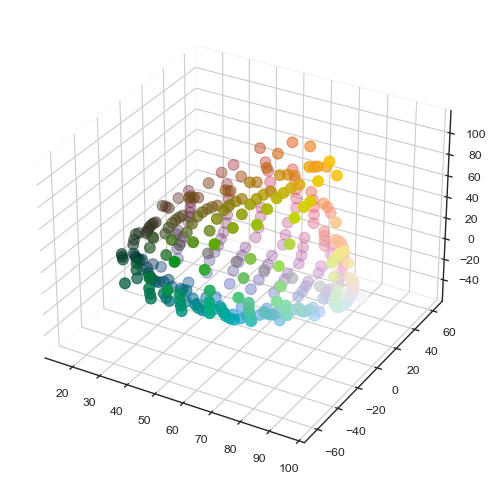

In [8]:
CIELAB_c = dict()

for coord in cielab_dict:
    CIELAB_c[cielab_dict[coord]] = image[coord[0]+1, coord[1]+1]


# plot CIELAB space as 3d scatter plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False


# Extract coordinates and colors from the dictionary
coordinates = list(CIELAB_c.keys())
colors = list(CIELAB_c.values())

# Convert RGB values to valid color format understood by Matplotlib
colors = [(r, g, b) for r, g, b in colors]

# Plot the points
ax.scatter(*zip(*coordinates), c=colors, s=60, marker='o')

# save to pdf
plt.savefig('figures/Figure_1b.pdf', 
            bbox_inches='tight', 
            pad_inches=0)

plt.show()

Sample of WCS languages:

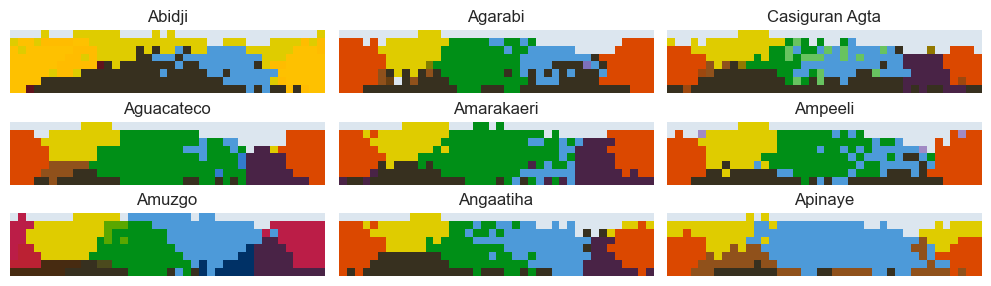

In [9]:
# plot a sample of 9 languages
plt.figure(figsize=(10, 3))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plot_color_grid(lg_color[i+1], rgb_dict, prior_m_matrix)
    plt.imshow(img, interpolation='none')
    plt.title(lang_info[i+1], fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.savefig('figures/WCS_sample.png', 
            bbox_inches='tight', 
            pad_inches=0)

### 1. Preprocessing and data generation

Preprocessing the data:

In [10]:
# only choose coordinates in the range (0, 0), (8, 40)
cielab_dict_ = {k: v for k, v in cielab_dict.items() if k[0] in range(0, 9) and k[1] in range(0, 41)}

# reverse keys and values in cielab_dict_
cielab_dict_r = {v: k for k, v in cielab_dict_.items()}

# convert cielab_dict_ to a list of tuples ordered from (0, 0) to (8, 40)
cielab_list = [cielab_dict_[k] for k in sorted(cielab_dict_.keys())]

Plotting the hypothetical partitions with the corresponding c and s parameters:

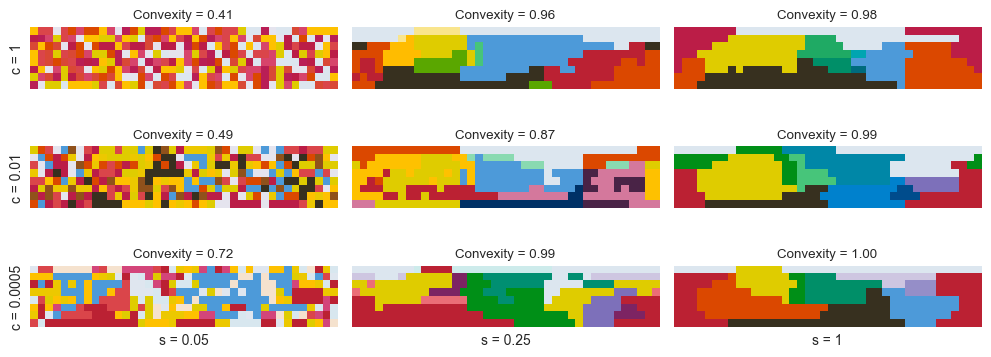

In [87]:
# plot 4 x 4 possible color clusters with parameter smooth in [0.1, 0.25, 0.5, 1] and conn in [0.1, 0.25, 0.5, 1]
fig, ax = plt.subplots(3, 3, figsize=(10, 4))

smooth_values = [0.05, 0.25, 1]
conn_values = [0.0005, 0.01, 1]
conn_values = [_ for _ in reversed(conn_values)]

for i, smooth in enumerate(smooth_values):
    for j, conn in enumerate(conn_values):
        a = ConvexCluster(X = np.zeros((8, 40)), 
                         d = 2, 
                         N = 10, 
                         s = smooth, 
                         c = conn,
                         coords = cielab_list,
                         reverse_labels = cielab_dict_r)
        labels = a.run()
        img = plot_color_grid(labels, rgb_dict, prior_m_matrix)
        ax[i, j].imshow(img, 
                        interpolation='none')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'Convexity = {a.degree_of_convexity():.2f}')
        # remove border
        for spine in ax[i, j].spines.values():
            spine.set_visible(False)
        # ax[i, j].set_title(f'MDL = {mdl(labels):.2f}')
        
# Label the conn values on the y-axis
for i, conn in enumerate(conn_values):
    ax[i, 0].set_ylabel('c = ' + str(conn), fontsize=10)

# Label the smooth values on the x-axis
for j, smooth in enumerate(smooth_values):
    ax[2, j].set_xlabel('s = ' + str(smooth), fontsize=10)

plt.tight_layout()
# save the plot as pdf
plt.savefig('figures/Figure_2.pdf', 
            bbox_inches='tight', 
            pad_inches=0)
plt.show()

Generate artificial grids (commented out, as the data is already generated):

In [125]:
# results = generate_grid(n = 30000, 
#                         d = 2, 
#                         X = 8,
#                         Y = 40,
#                         n_low = 3,
#                         n_high = 15,
#                         cielab_list = cielab_list,
#                         cielab_dict = cielab_dict,
#                         cielab_dict_r = cielab_dict_r,
#                         prior_m_matrix = prior_m_matrix)

Generating Grid:   0%|          | 0/30000 [00:00<?, ?it/s]

Load the data:

In [12]:
# import results from pickle
with open('data/convex_cluster_results_0508.pkl', 'rb') as f:
    results = pickle.load(f)

# write results to pickle
# with open('data/convex_cluster_results_0508.pkl', 'wb') as f:
#     pickle.dump(results, f)

mdl_values, conv_values, cost_values, categ, param_dict, lgs = results

# iterate over cost_values, if a value is inf, then remove it from the list and from the other lists
for i, val in enumerate(cost_values):
    if np.isinf(val):
        mdl_values.pop(i)
        conv_values.pop(i)
        categ.pop(i)
        cost_values.pop(i)

Estimate the Pareto front:

In [13]:
pareto_front_indices = non_dominated_front(mdl_values, cost_values)
pareto_front_points = [(mdl_values[i], cost_values[i]) for i in pareto_front_indices]

# find duplicates in either x or y and remove them
pareto_front_points = list(set(pareto_front_points))

x_pareto, y_pareto = zip(*pareto_front_points)

In [52]:
# create a smooth line over x_pareto and y_pareto using lowess
lowess = sm.nonparametric.lowess
smoothed = lowess(y_pareto, x_pareto, frac=0.6)

Read the generated data and extract the partitions and their metrics:

Calculate the distances to the Pareto front for the artificial data:

In [53]:
# for each point in (mdl_values, cost_values), calculate the distance to the points in the pareto front
distances = []

x_pareto = np.array(x_pareto)
y_pareto = np.array(y_pareto)

for i, j in zip(mdl_values, cost_values):
    distances.append(abs(np.min(np.sqrt((i - x_pareto)**2 + (j - y_pareto)**2))))

Compute the metrics for the WCS data:

In [54]:
# enumerate over grids in lg_color and calculate informativeness
informativeness_values = []
simplicity_values = []
categ_values = []
lg_ids = list(lg_color.keys())

for grid in lg_color:
    informativeness_values.append(informativeness(lg_color[grid], prior_m_matrix, cielab_dict))
    simplicity_values.append(compression(lg_color[grid]))
    categ_values.append(len(np.unique(lg_color[grid])))

# measure the degree of convexity for each grid in lg_color
convexity_values = degree_of_convexity_cielab(np.array([lg_color[lg] for lg in lg_ids]), cielab_dict, cielab_list)
# compute the number of categories for each grid in lg_color
categories_values = [len(np.unique(lg_color[grid])) for grid in lg_color]
# compute the distance to the pareto front for each grid in lg_color
distances_values = [abs(np.min(np.sqrt((simplicity_values[i] - x_pareto)**2 + 
                                   (informativeness_values[i] - y_pareto)**2))) for i in range(len(simplicity_values))]

In [55]:
# create a dataframe
df_lg = pd.DataFrame({'convexity': convexity_values,
                      'categories': categories_values,
                      'distance': distances_values,
                      'simplicity': simplicity_values,
                      'informativeness': informativeness_values,})

df_lg.to_csv('data/regression_data_nl.csv', index=False)

### 2. Analysis

Plot the artificial data and the Pareto front:

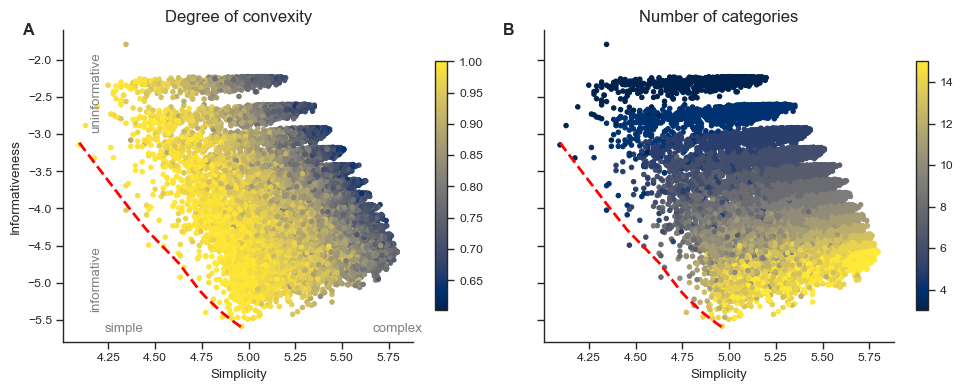

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
                               sharey=True)
letter_subplots()
sns.despine(top=True, right=True)
# Plot with convexity
scatter1 = ax1.scatter(mdl_values, cost_values, 
                       c=conv_values, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax1.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1,  
         linewidth=2, linestyle='--')
scatter1.set_rasterized(True)
ax1.text(-1.28, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.28, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.2, 0.04, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.text(-0.42, 0.04, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
ax1.set_title('Degree of convexity', fontsize=12)
cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.8)
# Plot with number of categories
scatter2 = ax2.scatter(mdl_values, cost_values, c=categ, 
                       cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax2.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1, 
         linewidth=2, linestyle='--')
# ax2.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
scatter2.set_rasterized(True)
ax2.set_xlabel('Simplicity')
ax2.set_title('Number of categories', fontsize=12)
# ax2.grid(linestyle='--', alpha=0.5)
cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.8)

plt.tight_layout()

plt.show()

Plot WCS data and the artificial data together:

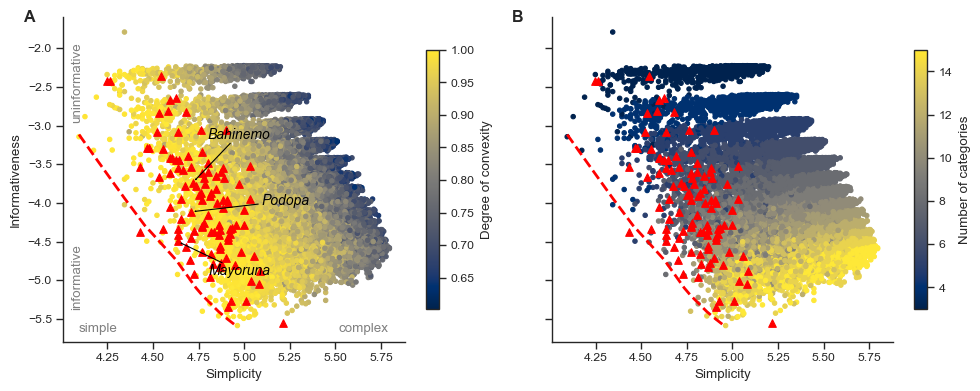

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
                               sharey=True)
letter_subplots()
sns.despine(top=True, right=True)
# Plot with convexity
scatter1 = ax1.scatter(mdl_values, cost_values, 
                       c=conv_values, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax1.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1,  
         linewidth=2, linestyle='--', label='Pareto front')
ax1.scatter(simplicity_values, informativeness_values, 
            c='red', marker='^', s=30, label='WCS languages')
# add labels to 2 points with minimum simplicity from lang_info
texts = []
for lg in [66, 83, 11]:
    text = ax1.text(simplicity_values[lg], informativeness_values[lg], 
                    lang_info[lg], fontsize=10, 
                    color='black', fontstyle = 'oblique')
    texts.append(text)
# Use adjust_text to add repulsion
adjust_text(texts, arrowprops=dict(arrowstyle='->',
                                    color='black'), 
                                    ax=ax1, expand=(4, 4))
scatter1.set_rasterized(True)
x = -0.13 # x position for text
ax1.text(-1.26 + x, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.26 + x, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.2 + x, 0.04, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.text(-0.42 + x, 0.04, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
# ax1.set_title('Degree of convexity', fontsize=12)
cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.8, label='Degree of convexity')
# legend on the top right corner with no frame
# ax1.legend(loc='upper right', frameon=False)

# Plot with number of categories
scatter2 = ax2.scatter(mdl_values, cost_values, c=categ, 
                       cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
scatter2.set_rasterized(True)
ax2.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1, 
         linewidth=2, linestyle='--')
ax2.scatter(simplicity_values, informativeness_values, c='red', marker='^', s=30)
# ax2.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
# scatter2.set_rasterized(True)
ax2.set_xlabel('Simplicity')
# ax2.set_title('Number of categories', fontsize=12)
# ax2.grid(linestyle='--', alpha=0.5)
cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.8, label='Number of categories')

plt.tight_layout()

# save the plot as pdf
plt.savefig('figures/Figure_3a.pdf', dpi=300, bbox_inches='tight')
plt.show()

Plot the distribution of distances to the Pareto front for the WCS data and the artificial data:

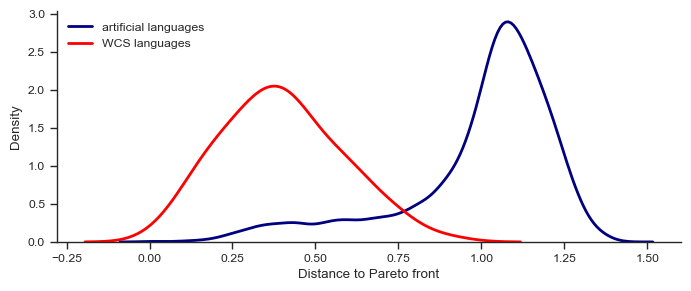

In [25]:
plt.figure(figsize=(7, 3))
# plt.hist(df['distance'], color='grey', 
#          alpha=0.5, label='artificial languages', density=True, bins=20)
sns.kdeplot(distances, color='navy', label='artificial languages', linewidth=2, common_norm=True)
sns.kdeplot(distances_values, color='red', label='WCS languages', linewidth=2, common_norm=True)
plt.legend(frameon=False, loc='upper left')
plt.xlabel('Distance to Pareto front')
plt.ylabel('Density')
sns.despine()
plt.tight_layout()
# save to png
plt.savefig('figures/distance_hist.png', dpi=300, bbox_inches='tight')
plt.show()

Pearson r = -0.89, p = 0.0000
Pearson r = -0.29, p = 0.0027
PearsonRResult(statistic=-0.2922184072114524, pvalue=0.0027429833105015217)


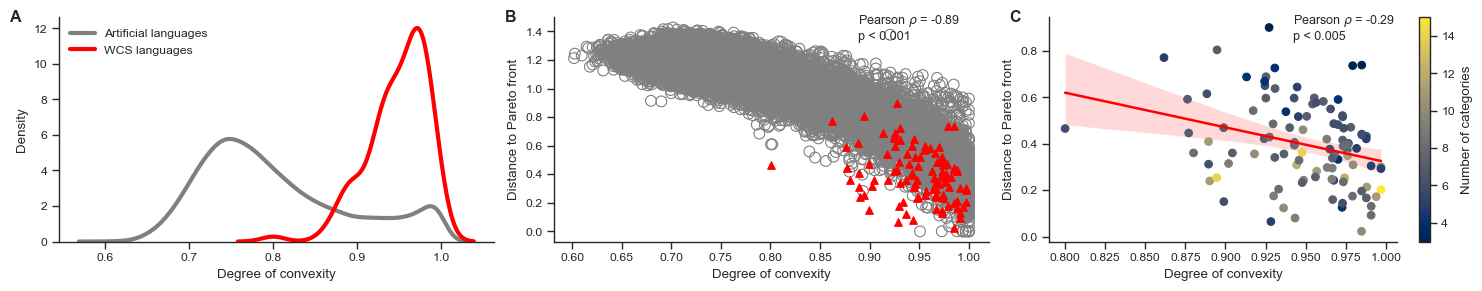

In [105]:
# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

letter_subplots()

## Subplot A
# Plot distribution of degrees of convexity
sns.kdeplot(conv_values, color='grey', alpha=1, label='Artificial languages', 
            fill=False, linewidth=3, ax=axes[0], common_norm=True)
sns.kdeplot(convexity_values, color='red', alpha=1, label='WCS languages', 
            fill=False, linewidth=3, ax=axes[0], common_norm=True)
axes[0].legend(frameon=False, loc='upper left')
axes[0].set_xlabel('Degree of convexity')
axes[0].set_ylabel('Density')
sns.despine(ax=axes[0])

## Subplot B
# Scatter plot with color bar
scatter = axes[1].scatter(conv_values, distances, color='grey', alpha=1, s=60, facecolors='none')
scatter.set_rasterized(True)
axes[1].scatter(convexity_values, distances_values, color='red', marker='^', s=30)
# Add correlation in the top right corner of the scatter plot
r, p = stats.pearsonr(conv_values, distances)
axes[1].text(0.7, 0.9, f'Pearson $\\rho$ = {r:.2f}\np < 0.001', 
             fontsize=9, transform=axes[1].transAxes)
axes[1].set_xlabel('Degree of convexity')
axes[1].set_ylabel('Distance to Pareto front')
sns.despine(ax=axes[1])

# print rounded p values and r values
print(f'Pearson r = {r:.2f}, p = {p:.4f}')

## Subplot C
# Scatter plot with seaborn regression plot
sns.regplot(x=convexity_values, y=distances_values, 
            scatter=False, color='red', ax=axes[2])
scatter = axes[2].scatter(convexity_values, distances_values, 
                          c=categories_values, alpha=1, s=30, cmap='cividis')
fig.colorbar(scatter, ax=axes[2], label='Number of categories')
# Calculate Pearson correlation
r, p = stats.pearsonr(convexity_values, distances_values)
axes[2].text(0.7, 0.9, f'Pearson $\\rho$ = {r:.2f}\np < 0.005', 
             fontsize=9, transform=axes[2].transAxes)
axes[2].set_xlabel('Degree of convexity')
axes[2].set_ylabel('Distance to Pareto front')
sns.despine(ax=axes[2])

# print rounded p values and r values
print(f'Pearson r = {r:.2f}, p = {p:.4f}')

print(stats.pearsonr(convexity_values, distances_values))

plt.tight_layout()
plt.savefig('figures/Figure_4.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [101]:
# average convexity for natural languages
avg_convexity = np.mean(convexity_values)
# standard deviation of convexity for natural languages
std_convexity = np.std(convexity_values)

print(f'Average degree of convexity for WCS languages: {avg_convexity:.2f}')
print(f'Standard deviation of degree of convexity for WCS languages: {std_convexity:.2f}')

Average degree of convexity for WCS languages: 0.95
Standard deviation of degree of convexity for WCS languages: 0.04


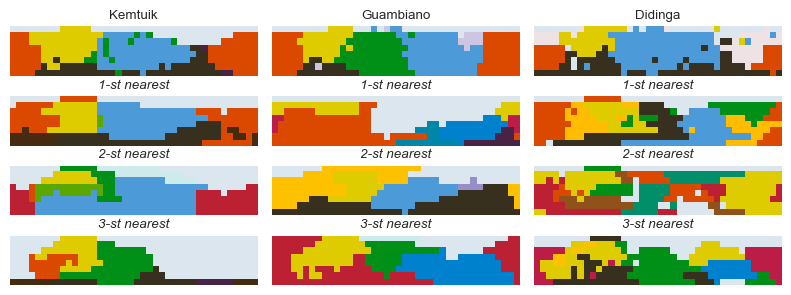

In [100]:
# lg_index = [66, 83, 11]
lg_index = np.random.choice(list(lg_color.keys()), 3, replace=False)

# Plot nearest neighbors for 3 languages
# plot_n_neighbours(lg_index, 4)
plot_n_neighbours(lg_index, 4, 'figure_3b', lg_color, prior_m_matrix, 
                  cielab_dict, rgb_dict, lang_info, mdl_values, cost_values, lgs)

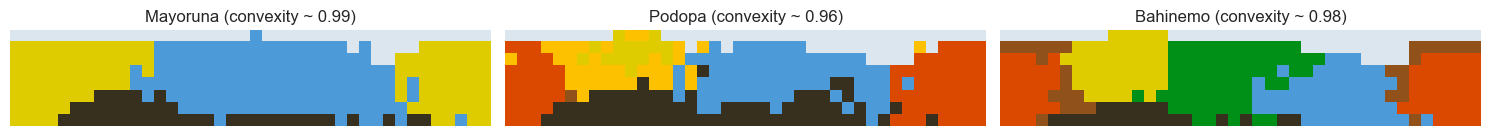

In [94]:
# plot lg_index = [66, 83, 11] and their corresponding convexity values
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, lg in enumerate(lg_index):
    img = plot_color_grid(lg_color[lg], rgb_dict, prior_m_matrix)
    axes[i].imshow(img, interpolation='none')
    axes[i].set_title(f'{lang_info[lg]} (convexity ~ {convexity_values[lg]:.2f})', fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()